# Comparison between my code and bibliography: The Journal of Physical Chemistry A
## Vol 123 / Issue 38
### On-Top Ratio for Atoms and Molecules

**Article Subscribed: August 22, 2019**  
*Authors: Rebecca K. Carlson, Donald G. Truhlar, Laura Gagliardi*

In [6]:
# Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("src")

from file_management import FileManager
from cluster_connection import ClusterConnection
from job_manager import JobManager
from slurm_manager import SlurmManager
from flux_correlation_indicator import FluxCorrelationIndicator
from molecule import Molecule
from basis import BasisSet
from method import Method
from input_specification import InputSpecification

In [7]:
def launch_ontop_calculation(molecule_name, method_name, basis_name):
        # Code to define molecule, method, and basis, then execute job and retrieve results
    
    # Placeholder: Move to project root if needed
    # os.chdir("..")  # Uncomment if needed to change directory
    
    # Define molecule, method, basis
    molecule = Molecule(name=molecule_name)  # Example placeholder
    method = Method(method_name)
    basis = BasisSet(basis_name)
    import re


# Regular expression to match parts between ( and , and between , and )
    match = re.search(r'\(([^,]+),\s*([^)]+)\)', method_name)
    if match:
        part1 = match.group(1).strip()
        part2 = match.group(2).strip()

    
    job_name = molecule_name[:2]+part1+part2+basis_name.replace('-','')

    
    # Initialize dataframe to None
    df = None
    with ClusterConnection(config_file="utils/cluster_config.json") as connection:
        file_manager = FileManager(connection)
        job_manager = JobManager(connection, file_manager, SlurmManager())
        flux_manager = FluxCorrelationIndicator(connection, file_manager, job_manager)
    
        # Define the job name and execute the flux
        flux_manager.handle_flux(job_name, molecule, method, basis)
        df = file_manager.get_results(job_name)
        return df


In [8]:
# Function to obtain atomic indicator
def obtain_atomic_indicator(df):
    # Filter data where y and z are approximately 0

    # Convert x and y from Hartree to Ångstroms
    df['x'] = df['x'] * 0.529177
    df['y'] = df['y'] * 0.529177
    
    # Create indicator column
    df['indicator'] = 2 * df['on_top'] / (df['density']) ** 2
    
    # Select relevant columns
    result_df = df[['x', 'y', 'indicator']].dropna(subset=['indicator'])
    return result_df 


In [9]:
def plot_comparison(molecule, calculated_indicator, limit):
    """
    Displays a side-by-side comparison of the reference image and calculated contour and line plots for a given atom.
    Automatically determines the largest square region for the grid.

    Parameters:
    - molecule (str): Name of the atom (e.g., 'He', 'Ne', 'Ar').
    - calculated_indicator (pd.DataFrame): DataFrame containing calculated OTR values with 'x', 'y', and 'indicator' columns.
    """
    
    # Load the reference image
    img_path = f'./notebooks/figures/{molecule.lower()}.png'
    try:
        reference_img = Image.open(img_path)
    except FileNotFoundError:
        print(f"Reference image for {molecule} not found at {img_path}. Placeholder will be shown.")
        reference_img = None
    

    # Filter data to only include values within [0, q]
    filtered_data = calculated_indicator[(calculated_indicator['x'] <= limit) & (calculated_indicator['y'] <= limit)]
    
    # Update unique values for x and y based on filtered data
    unique_x = np.sort(filtered_data['x'].unique())
    unique_y = np.sort(filtered_data['y'].unique())
    num_x = len(unique_x)
    num_y = len(unique_y)
    
    # Reshape data for contour plot
    try:
        # Create meshgrid for x and y values
        x_vals, y_vals = np.meshgrid(unique_x, unique_y, indexing='ij')
        indicator_vals = filtered_data['indicator'].values.reshape((num_x, num_y))
    except ValueError as e:
        print("Error reshaping 'indicator' column after filtering.")
        print(f"Expected grid size: ({num_x}, {num_y}) -> Total: {num_x * num_y}")
        print(f"Actual 'indicator' size after filtering: {len(filtered_data['indicator'])}")
        return

    # Set up the figure layout
    fig = plt.figure(figsize=(14, 12))
    fig.suptitle(f'Comparison of On-Top Ratio (OTR) for {molecule}', fontsize=16)

    # Left: Reference Image (Bibliography Results) - occupying the entire left side
    ax1 = fig.add_subplot(1, 2, 1)
    if reference_img is not None:
        ax1.imshow(reference_img)
        ax1.axis('off')
        ax1.set_title(f'Bibliography Results: {molecule}')
    else:
        ax1.text(0.5, 0.5, 'Reference Image Not Available', ha='center', va='center', fontsize=12)
        ax1.axis('off')
    
    # Right Top: Calculated Contour Plot with increased contour levels
    ax2 = fig.add_subplot(2, 2, 2)
    num_levels = 20  # Adjust this as needed
    contour = ax2.contourf(x_vals, y_vals, indicator_vals, cmap='rainbow', levels=num_levels)
    fig.colorbar(contour, ax=ax2, orientation='vertical')
    ax2.set_title(f'Calculated OTR Contour Plot: {molecule}')
    ax2.set_xlabel('z(Å)')
    ax2.set_ylabel('z(Å)')
    ax2.set_aspect('equal')  # Match aspect ratio
    
    # Right Bottom: Calculated Line Plot, filtered to x <= 1
    ax3 = fig.add_subplot(2, 2, 4)
    line_data = calculated_indicator[(calculated_indicator['y'] <= 0.000001) & (calculated_indicator['x'] <= limit)]
    ax3.plot(line_data['x'], line_data['indicator'], color='black')
    ax3.set_title(f'Calculated OTR Line Plot: {molecule}')
    ax3.set_xlabel('z(Å)')
    ax3.set_ylabel('R')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Atoms

### He

In [ ]:
molecule = 'helium'
df = launch_ontop_calculation(molecule,'CASSCF(2,2)','dec-pc-4');

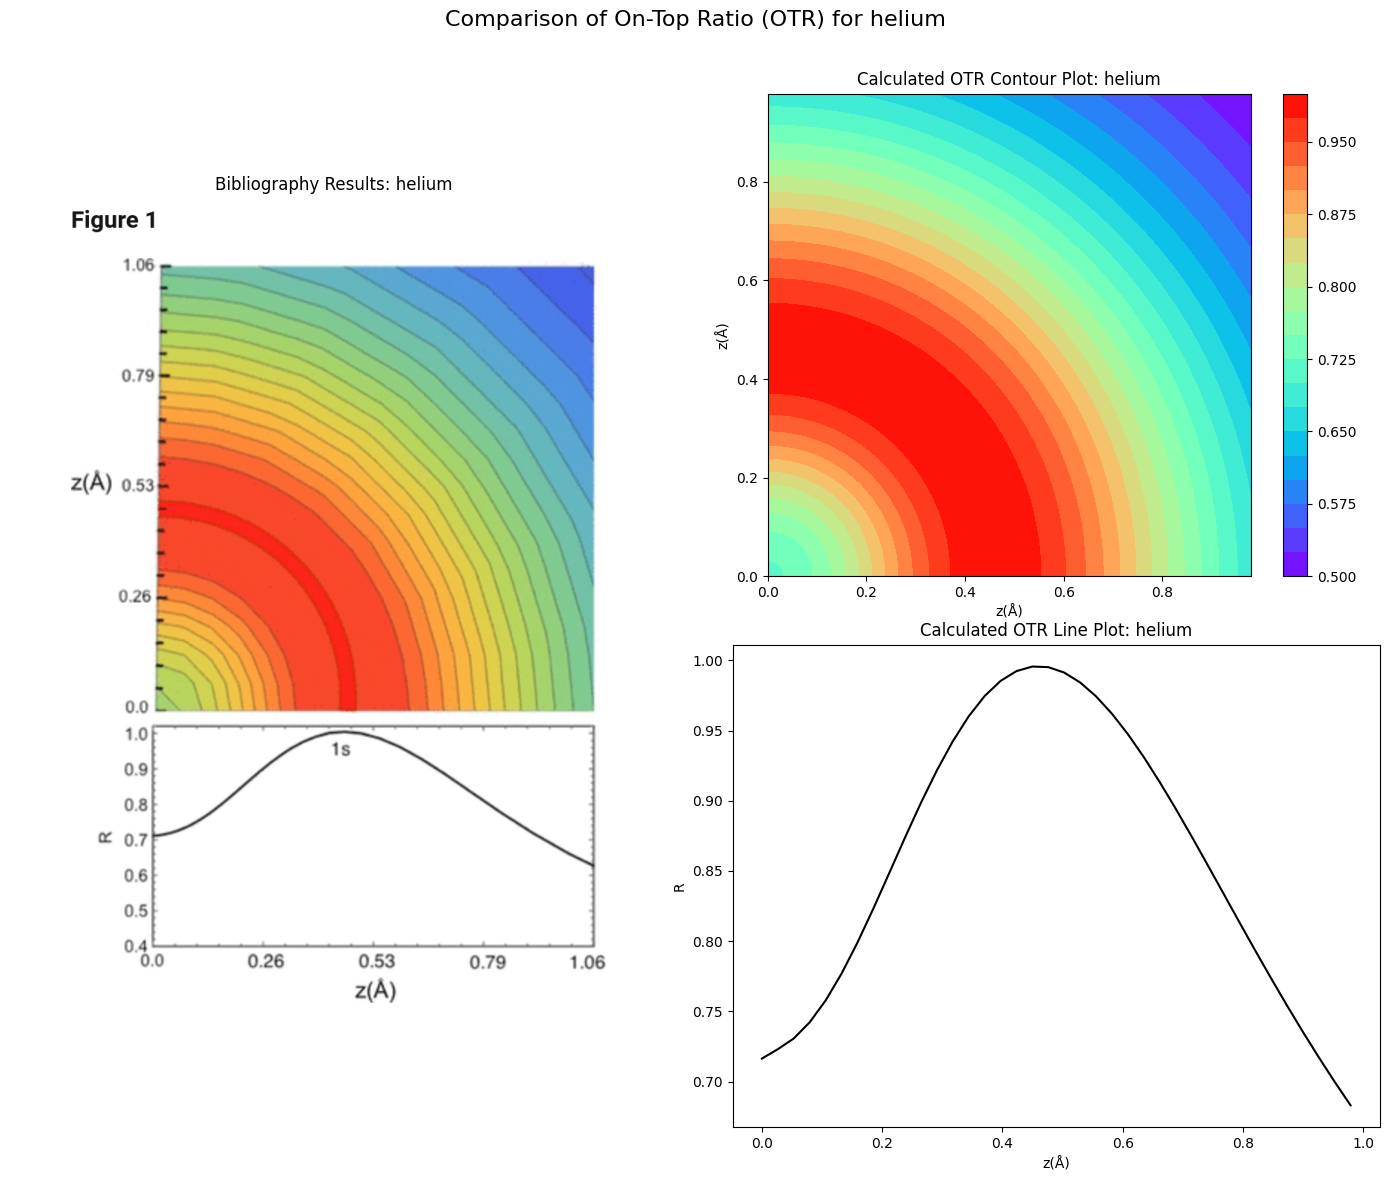

In [6]:
plot_comparison(molecule, obtain_atomic_indicator(df),limit=1)

### Ne

In [ ]:
molecule = 'neon'
df = launch_ontop_calculation(molecule,'CASSCF(10,10)','dec-pc-4');

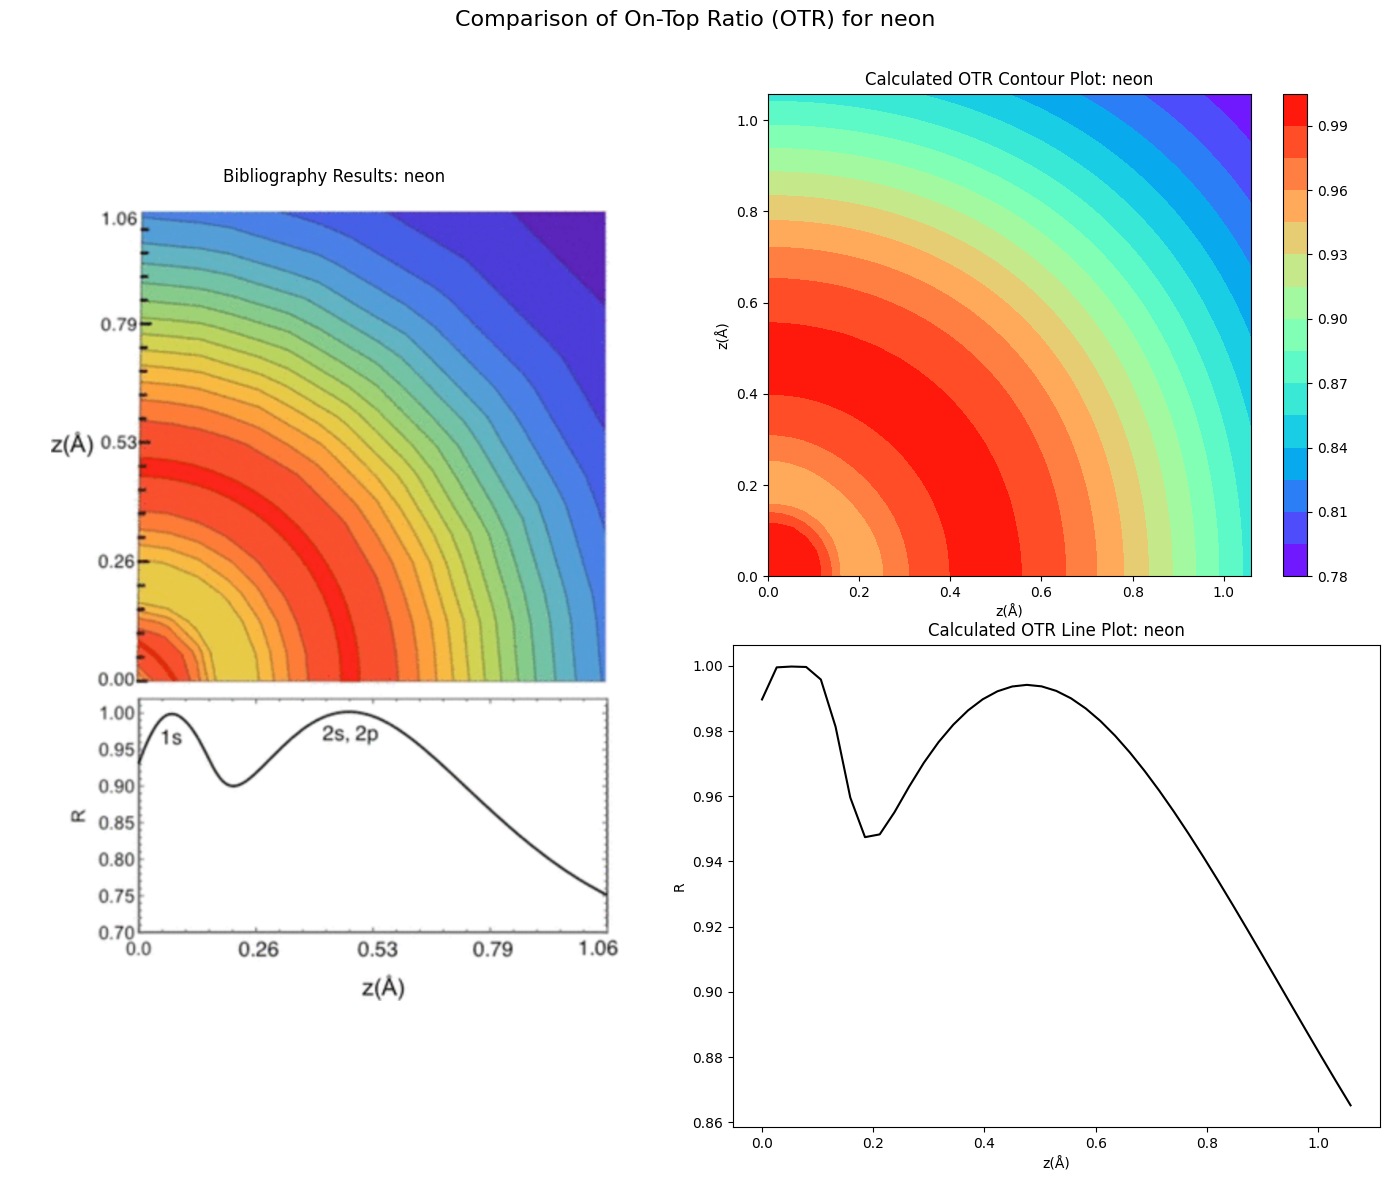

In [8]:
plot_comparison(molecule, obtain_atomic_indicator(df),limit=1.09)

### Ar

In [ ]:
molecule = 'argon'
df = launch_ontop_calculation(molecule,'CASSCF(18,18)','dec-pc-4');

Geometry for argon successfully loaded.
Connected to atlas.
Command output: 
Uploaded slurm_scripts/ar1818decpc4_dmn.slurm to /dipc/javidom/proyect-3-indicator/ar1818decpc4/ar1818decpc4_dmn.slurm on the cluster.
Command output: 
Command output: -rwxrwxrwx

Command output: exists



In [ ]:
plot_comparison(molecule, obtain_atomic_indicator(df),limit=1.59)

In [ ]:
## Molecules